# work it out in numpy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
X = np.ones((200, 512))
d_model = 512
rows, cols = np.indices(X.shape)

In [2]:
rows, cols

(array([[  0,   0,   0, ...,   0,   0,   0],
        [  1,   1,   1, ...,   1,   1,   1],
        [  2,   2,   2, ...,   2,   2,   2],
        ...,
        [197, 197, 197, ..., 197, 197, 197],
        [198, 198, 198, ..., 198, 198, 198],
        [199, 199, 199, ..., 199, 199, 199]]),
 array([[  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511],
        ...,
        [  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511]]))

In [3]:
numerator = np.where(cols % 2, np.cos(rows), np.sin(rows))
denominator = (10_000**((2*cols)/d_model))
encodings = numerator / denominator
encodings.shape

(200, 512)

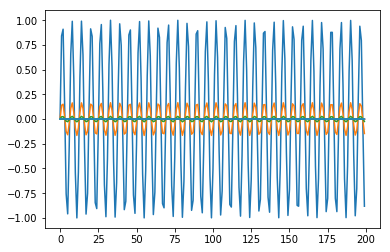

In [4]:
# sinusoids along each dimmension of the encoding
for encoding in encodings.T[::50]:
    plt.plot(encoding)

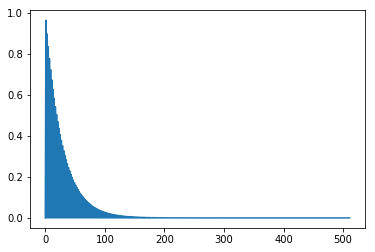

In [6]:
plt.plot(encodings[0])

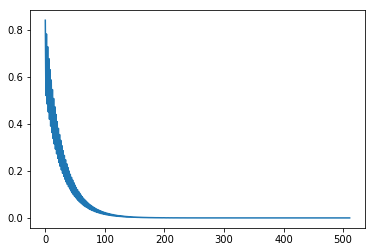

In [7]:
plt.plot(encodings[1])

# Now in keras

In [8]:
import keras.backend as K
import tensorflow as tf
from keras.layers import Embedding, Input, Lambda

Using TensorFlow backend.


In [9]:
input_ = Input(shape=(None,))

In [10]:
embedding = Embedding(input_dim=10, output_dim=512)(input_)

In [11]:
embedding

<tf.Tensor 'embedding_1/embedding_lookup:0' shape=(?, ?, 512) dtype=float32>

In [12]:
embedding.shape

TensorShape([Dimension(None), Dimension(None), Dimension(512)])

## mimic np.indices

In [13]:
def indices(n_rows, n_cols):
    rows = K.arange(n_rows)
    cols = K.arange(n_cols)
    col_indices = K.reshape(K.tile(cols, [n_rows]), (n_rows, n_cols))
    row_indices = K.transpose(K.reshape(K.tile(rows, [n_cols]), (n_cols, n_rows)))
    return row_indices, col_indices

In [14]:
K.eval(K.variable(10, dtype='int32'))

10

In [15]:
rows, cols = indices(200, 512)

In [16]:
K.eval(rows), K.eval(cols)

(array([[  0,   0,   0, ...,   0,   0,   0],
        [  1,   1,   1, ...,   1,   1,   1],
        [  2,   2,   2, ...,   2,   2,   2],
        ...,
        [197, 197, 197, ..., 197, 197, 197],
        [198, 198, 198, ..., 198, 198, 198],
        [199, 199, 199, ..., 199, 199, 199]], dtype=int32),
 array([[  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511],
        ...,
        [  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511]], dtype=int32))

In [17]:
# try it with uknown dimmension
row_shape = K.shape(embedding)[1]
col_shape = K.shape(embedding)[2]
print(row_shape, col_shape)
rows, cols = indices(row_shape, col_shape)
rows, cols

Tensor("strided_slice:0", shape=(), dtype=int32) Tensor("strided_slice_1:0", shape=(), dtype=int32)


(<tf.Tensor 'transpose_1:0' shape=(?, ?) dtype=int32>,
 <tf.Tensor 'Reshape_2:0' shape=(?, ?) dtype=int32>)

# try stacking it on top of the word embeddings

In [37]:
def f(X):
    sequence_dim = K.shape(X)[1]
    word_vector_dim = K.shape(X)[2]
    rows, cols = indices(sequence_dim, word_vector_dim)
    rows, cols = K.cast(rows, dtype='float32'), K.cast(cols, dtype='float32')
    numerator = K.switch(cols % 2, K.sin(rows), K.cos(rows))
    denominator = 10_000**((2*cols)/d_model)
    return X + (numerator / denominator)
L = Lambda(f, output_shape=lambda x: x)

In [38]:
x = L(embedding)

In [39]:
from keras.models import Model
model = Model(inputs=[input_], outputs=x)

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 512)         5120      
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 512)         0         
Total params: 5,120
Trainable params: 5,120
Non-trainable params: 0
_________________________________________________________________


In [45]:
X = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
    [1, 5, 9],
])
model.predict(X)

array([[[ 0.9743623 , -0.01274883,  0.95067805, ...,  0.0320926 ,
          0.03478463, -0.02646897],
        [ 0.5066123 ,  0.7987114 ,  0.5397179 , ...,  0.00977338,
          0.01289985,  0.01100378],
        [-0.41738924,  0.8667457 , -0.43422997, ...,  0.00582566,
         -0.03258291,  0.00488034]],

       [[ 1.0335181 , -0.02512053,  0.9661073 , ...,  0.04686518,
          0.00228142, -0.02522037],
        [ 0.5121797 ,  0.8554815 ,  0.5138655 , ..., -0.03134329,
          0.00917052, -0.00323523],
        [-0.4131518 ,  0.9252798 , -0.4018725 , ...,  0.04365337,
         -0.041605  ,  0.0104285 ]],

       [[ 0.9931059 ,  0.01656367,  0.94558245, ...,  0.0185032 ,
         -0.01628195, -0.03560181],
        [ 0.51993567,  0.8424337 ,  0.51047677, ..., -0.0019523 ,
         -0.04640086, -0.03394149],
        [-0.38091275,  0.88810533, -0.39271238, ...,  0.02009666,
          0.03624954, -0.0105289 ]],

       [[ 0.9743623 , -0.01274883,  0.95067805, ...,  0.0320926 ,
          

# look at positional encodings only

In [ ]:
i = Input(shape=(None, None,))

In [ ]:
model = Model(inputs=[i], outputs=[L(i)])

In [ ]:
model.summary()

In [ ]:
p = model.predict(np.zeros((1, 1, 512)))
p

In [ ]:
plt.plot(p[0])